# Analysis of precipitation data using extreme value methods

This notebook demonstrates several methods for assessing the frequency of extreme precipitation events.

For reference, here is a paper using extreme value techniques to study rainfall in Brazil:

https://link.springer.com/article/10.1007/s42452-020-03199-8

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genpareto, genextreme
from scipy.optimize import minimize
from scipy.special import gamma
from pathlib import Path

In [4]:
import os
import pandas as pd

# Download the NCDC data, also available from this site:
#  https://www.ncei.noaa.gov/access/search/data-search/daily-summaries

base_url = "https://www.ncei.noaa.gov/data/daily-summaries/access"

target_dir = "/Users/liangqi/Library/Mobile Documents/com~apple~CloudDocs/Stats-504/precip"

files = ["USW00094847.csv", "USW00012839.csv",]

for f in files:
    df = pd.read_csv(os.path.join(base_url, f))
    df.to_csv(os.path.join(target_dir, f + ".gz"))

/var/folders/1m/g_2xpnh912g613fymwqbt4gr0000gn/T/ipykernel_97826/1255225193.py:14: DtypeWarning: Columns (17,19,21,23,25,27,29,31,33,35,39,41,43,45,49,51,53,55,57,59,61,63,65,67,69,71,85,91,93,95,97,99,101,103,105,107,109,111,113,115) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(base_url, f))
/var/folders/1m/g_2xpnh912g613fymwqbt4gr0000gn/T/ipykernel_97826/1255225193.py:14: DtypeWarning: Columns (17,19,21,23,25,27,29,31,37,39,41,43,45,49,51,53,55,57,59,61,63,65,73,75,77,79,83,85,87,89,91,93,95,97) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(base_url, f))


Below we define several functions that implement methods for extreme value analysis.  After defining these functions, we can use them to analyze the precipitation data.

In [6]:
def tail_shape(z, p0=0.1, family="powerlaw"):
    """
    Returns values x, p such that the slope of p on x estimates the
    shape parameter (tail index) of a distribution with power-law
    tails (if family='powerlaw'), or the rate parameter of a
    distribution with exponential tails (if family='exponential').
    The upper p0 fraction of the data in z are used to produce (x, p).
    The returned values in x are the order statistics of z in the
    exponential case, and the log order statistics of z in the powerlaw
    case. The returned values in p are derived from probability
    points.  Scatterplot p against x to get a visualization of the
    tail shape.
    """

    if family not in ["exponential", "powerlaw"]:
        raise ValueError("Unknown family %s" % family)

    z = z.copy()
    p = 1 - p0
    z = np.asarray(z)
    z.sort()
    n = len(z)
    m = int(np.around(p*n))
    x = z[m-1:]
    if family == "powerlaw":
        x = np.log(x + 1e-6)
    p = np.log(1 - np.arange(m, n+1) / (n+1))
    return x, p

In [7]:
def fit_tail_reg(x, ax, p0=0.99, family="powerlaw"):
    """
    Use least squares regression in the upper 'p0' fraction of the right
    tail of a quantile plot to estimate the shape parameter, and add the
    best fit line to the plot in axes 'ax'.
    """

    x, p = tail_shape(x, p0=p0, family=family)

    ax.plot(x, p, color="orange")

    # Estimate the tail index using a least squares fit to the order
    # statistics.
    alpha_hat = -np.cov(p, x)[0, 1] / np.var(x)
    icept = p.mean() + alpha_hat*x.mean()

    # The coordinates of the best-fit line
    xx = np.asarray([x.min(), x.max()])
    yy = icept - alpha_hat*xx

    ax.plot(xx, yy, color="purple")

    return icept, alpha_hat

In [8]:
def hill(z, k=200):
    """
    Estimate the tail index of a distribution with poower law tails using Hill's
    estimator, based on the upper k order statistics.
    """

    z = np.sort(z)
    z = np.log(z[-k:])
    return 1 / (z[1:] - z[0]).mean()

In [9]:
def plot_hill(z):
    """
    Plot the Hill estimate of the tail index for a range
    of values of the tuning parameter k.
    """

    kv = np.arange(20, 501, 5)
    ta = np.asarray([hill(z, k=k) for k in kv])

    plt.clf()
    ax = plt.axes()
    plt.grid(True)
    ax.set_title("Hill estimate of the tail index")
    ax.plot(kv, ta)
    ax.set_xlabel("k", size=16)
    ax.set_ylabel("Tail index estimate", size=16)
    ax.set_ylim(2.5, 5)
    plt.show()

In [10]:
def fit_gev(x):
    """
    Fit a generalized extreme value distribution (GEV) using maximum likelihood
    estimation to the data in 'x'. Probability weighted moments are used to obtain
    starting values:
    https://www.stat.cmu.edu/technometrics/80-89/VOL-27-03/v2703251.pdf
    
    The returned frozen GEV distribution follows the scipy parameterization:
    
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genextreme.html
    
    Note that this differs from another common parameterization, which is the one
    used on Wikipedia:
    
    https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution
    """

    x = np.sort(x)
    n = len(x)

    # Plotting positions
    pp = np.arange(1/2, n + 1/2) / n

    # Calculate the first three probability weighted moments
    b = np.zeros(3)
    for r in range(3):
        b[r] = np.dot(pp**r, x) / n

    # The PWM estimator of Hoskins et al.
    c = (2*b[1] - b[0]) / (3*b[2] - b[0])  - np.log(2) / np.log(3)
    shape = 7.8590*c + 2.9554*c**2
    scale = (2*b[1] - b[0]) * shape / (gamma(1 + shape) * (1 - 1/2**shape))
    loc = b[0] + scale*(gamma(1 + shape) - 1) / shape
    ge = genextreme(shape, loc=loc, scale=scale)
    
    # Get the MLE
    def f(par):
        shape, loc, logscale = par
        d = genextreme(shape, loc=loc, scale=np.exp(logscale))
        return -d.logpdf(x).sum()

    logscale = np.log(scale)
    x0 = np.asarray([shape, loc, logscale])
    rr = minimize(f, x0, method="powell")
    shape, loc, logscale = rr.x
    ge = genextreme(shape, loc=loc, scale=np.exp(logscale))
    return ge

In [11]:
def block_max(dx):
    """
    Calculate the maximum precipitation value for each complete year,
    and fit a generalized extreme value (GEV) distribution to the
    data.  Then use the fitted model to calculate returns for a sequence
    of time horizons, and create a QQ plot to assess goodness-of-fit.
    
    Returns the fitted generalized extreme value distribution model.
    """

    # Get the annual maximum for all complete years
    dx = dx.query("year > 1958 & year < 2023")
    yrmx = dx.groupby("year")["PRCP"].agg(np.max)
    
    # Fit a generalized extreme value distribution to the block maxima.
    gev = fit_gev(yrmx)

    # m-observation returns
    rr = pd.DataFrame({"Years": [10, 100, 500, 1000]})
    rr["Return"] = gev.ppf(1 - 1/rr.Years)
    print(rr)

    # Make a QQ plot to assess goodness of fit of the GEV model
    z = np.sort(yrmx)
    n = len(z)
    pp = np.arange(1, n + 1) / (n + 1)
    qq = gev.ppf(pp)

    plt.clf()
    ax = plt.axes()
    plt.grid(True)
    ax.plot(qq, z)
    ax.set_xlabel("GEV quantiles")
    ax.set_ylabel("Order statistics")
    ax.set_title("GEV fit to annual maxima")
    plt.show()

    return gev

In [12]:
def gp_estimate(z):
    """
    Estimate the parameters of a generalized Pareto distribution
    using the empirical Bayes method of Zhang and Stephens.
    https://www.jstor.org/stable/pdf/40586625.pdf
    
    Returns the fitted generalized Pareto model. See the link below for
    details about how the distribution is parameterized:
    
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genpareto.html
    """

    # The prior is discrete and data-adaptive, based on these parameters
    z = np.sort(z)
    n = len(z)
    xstar = z[int(np.round(n/4 + 0.5))]
    m = np.ceil(20 + np.sqrt(n))
    xmax = z.max()

    # The grid on which the prior is supported
    jj = np.arange(1, m+1)
    tgrid = 1/xmax + (1 - np.sqrt(m/(jj-0.5))) / (3 * xstar)

    # The profile log likelihood function
    def profile(theta):
        k = -np.log(1 - theta*z).mean()
        return n*(np.log(theta/k) + k - 1)

    # The posterior distribution
    ltg = np.asarray([profile(t) for t in tgrid])
    ltg -= ltg.max()
    Ltg = np.exp(ltg)
    Ltg /= Ltg.sum()
    
    # The posterior is a generalized Pareto with these parameters
    theta_hat = np.dot(Ltg, tgrid)
    k_hat = -np.log(1 - theta_hat*z).mean()
    scale_hat = k_hat / theta_hat

    # Return the posterior distribution
    return genpareto(-k_hat, scale=scale_hat)

In [56]:
def eb_analysis(z, thresh):
    """
    Fit a generalized Pareto model to the exceedances derived from z,
    using empirical Bayes estimation, and create a QQ plot to assess
    the goodness-of-fit.
    """

    # Exceedances
    z = z[z > thresh] - thresh

    # Empirical Bayes estimate of Zhang and Stephens.
    eb = gp_estimate(z)

    n = len(z)
    pp = np.linspace(1/2, n - 1/2, n) / n # plotting positions
    qq = eb.ppf(pp)
    z = np.sort(z)

    # QQ plot to show goodness of fit
    plt.clf()
    ax = plt.axes()
    plt.grid(True)
    ax.set_title("EB: shape=%.3f scale=%.3f, tail=%.2f" % (eb.args[0], eb.kwds["scale"], 1/eb.args[0]))
    ax.plot(qq, z)
    plt.xlabel("GP quantiles (EB)", size=16)
    plt.ylabel("Order statistics", size=16)
    #plt.show()
    plt.savefig('eb')

    return eb

In [48]:
# def plot_tails(z, p0, thresh, family):
#     """
#     Plot the tail of the estimated CDF based on the upper 'p0' proportion of the data in z.  
#     If family is 'exponential' use a semi-log plot, if family is 'powerlaw' use a log/log plot.
#     """

#     n = len(z)

#     # The number of selected observations
#     m = int(np.around(p0*n))

#     xlabel = "log Q(p)" if family == "powerlaw" else "Q(p)"

#     plt.clf()
#     ax = plt.axes()
#     plt.grid(True)
#     icept, alpha = fit_tail_reg(z, ax, p0=p0, family=family)
#     ax.set_xlabel(xlabel, size=16)
#     ax.set_ylabel("log(1-p)", size=16)
#     ti = "%s model, threshold=%.1f, top %.1f%% (n=%d), alpha=%.3f" %\
#            (family.title(), thresh, 100*p0, m, alpha)
#     plt.title(ti)
#     plt.show()

def plot_tails(ax, z, p0, thresh, family):
    """
    Plot the tail of the estimated CDF based on the upper 'p0' proportion of the data in z.
    If family is 'exponential', use a semi-log plot; if 'powerlaw', use a log-log plot.
    """
    n = len(z)
    m = int(np.around(p0 * n))  # Number of selected observations

    xlabel = "log Q(p)" if family == "powerlaw" else "Q(p)"
    
    # Clear the individual subplot instead of the full figure
    ax.grid(True)
    
    # Call fit_tail_reg and plot (assuming fit_tail_reg modifies ax)
    icept, alpha = fit_tail_reg(z, ax, p0=p0, family=family)
    
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel("log(1-p)", size=12)
    title = f"{family.title()} model, threshold={thresh:.1f}, top {100*p0:.1f}% (n={m}), alpha={alpha:.3f}"
    ax.set_title(title, fontsize=10)

In [15]:
def check_gp_estimate(shape, scale, thresh, n=100000):
    z = genpareto.rvs(shape, scale=scale, size=n)
    z = z[z > thresh] - thresh
    eb = gp_estimate(z)
    return eb, z

In [16]:
def mobs_return(z, mr, thresh, family="exponential", gp=None):
    """
    Calculate the m-observation returns for the data in z, using either
    an exponential or generalized Pareto model.
    """

    z = np.asarray(z)
    n = len(z)

    # Select only extreme values and translate back to the origin
    ix = np.flatnonzero(z >= thresh)
    q = len(ix) / n # proportion of values exceeding the threshold
    z = z[ix]
    z -= thresh

    pr = 1 - 1 / (q * mr)

    if family == "exponential":
        mn = z.mean()
        print("Mean = %.2f" % mn)
        m0 = thresh - mn*np.log(1 - pr)
    elif family == "generalizedpareto":
        print("Shape=%.2f" % eb.args[0])
        print("Scale=%.2f" % eb.kwds["scale"])
        m0 = thresh + gp.ppf(pr)
    else:
        raise ValueError("!!")

    return m0

Change this to point to the location of the data, matching the path name in get_data.py

In [17]:
target_dir = Path("/Users/liangqi/Library/Mobile Documents/com~apple~CloudDocs/Stats-504/precip")

Choose a specific location to analyze.

In [18]:
fname = "USW00094847.csv" # Detroit
#fname = "USW00012839.csv" # Miami

In [19]:
df = pd.read_csv(target_dir / ("%s.gz" % fname), parse_dates=["DATE"],
                 low_memory=False)

We only care about these two variables, which must not be missing.  "PRCP" is the 24-hour rainfall total, recorded in tenths of a millimeter.

In [20]:
df = df[["DATE", "PRCP"]].dropna()

Add a year variable for block-maxima (GEV) analyses

In [21]:
df["year"] = df["DATE"].dt.year

Convert precipitation to millimeters

In [22]:
df["PRCP"] /= 10

The data may be sorted already, but sort again just to be sure

In [23]:
df = df.sort_values(by="DATE")

Display the first few rows of data.

In [24]:
df.head()

,DATE,PRCP,year
1515,1958-12-01,0.0,1958
1516,1958-12-02,0.0,1958
1517,1958-12-03,0.0,1958
1518,1958-12-04,0.0,1958
1519,1958-12-05,1.3,1958


Use this threshold (units are mm) for calculating exceedances

In [25]:
thresh = 10.0
(df["PRCP"] >= thresh).mean()

0.0732484076433121

Plot the data as a time series

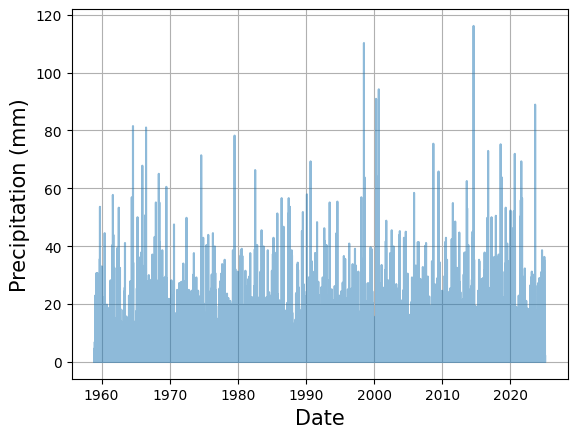

In [26]:
plt.clf()
plt.grid(True)
plt.plot(df["DATE"], df["PRCP"], "-", alpha=0.5)
plt.xlabel("Date", size=15)
plt.ylabel("Precipitation (mm)", size=15)
plt.show()

Plot the data as a histogram.  A histogram is not useful for studying extreme values.

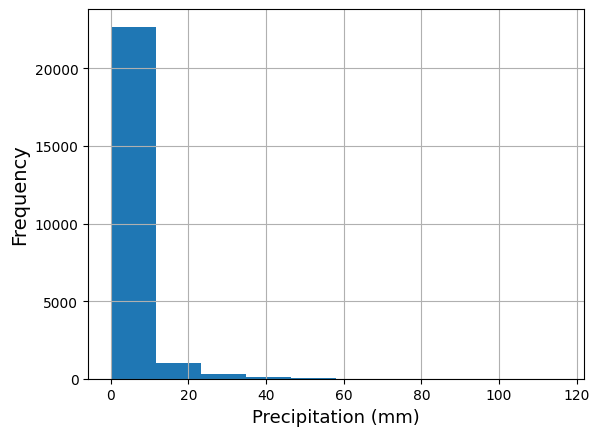

In [27]:
plt.clf()
plt.grid(True)
plt.hist(df["PRCP"])
plt.xlabel("Precipitation (mm)", size=13)
plt.ylabel("Frequency", size=14)
plt.show()

Plot the data as an (empirical) CDF.  This is not a very helpful approach for judging the structure of the tail of a probability distribution.

Text(0, 0.5, 'Cumulative probability')

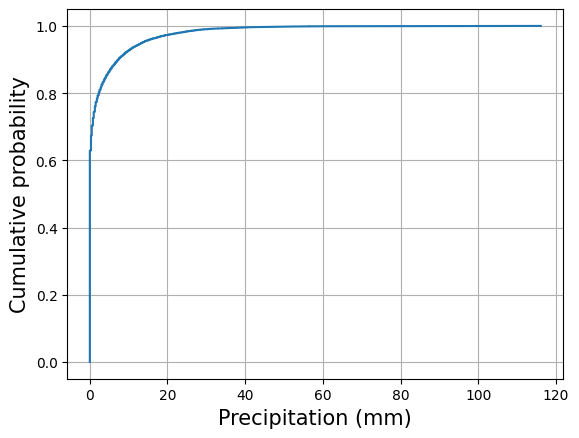

In [28]:
plt.clf()
plt.grid(True)
x = np.sort(df["PRCP"])
p = np.linspace(0, 1, len(x))
plt.plot(x, p, "-")
plt.xlabel("Precipitation (mm)", size=15)
plt.ylabel("Cumulative probability", size=15)

Plot the data as an (empirical) complementary CDF (also known as the ccdf or survival function)

Text(0, 0.5, 'Complementary cumulative probability')

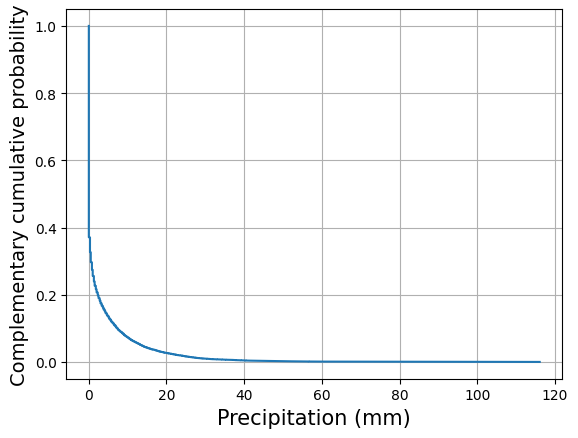

In [29]:
plt.clf()
plt.grid(True)
x = np.sort(df["PRCP"])
p = np.linspace(0, 1, len(x))
plt.plot(x, 1 - p, "-")
plt.xlabel("Precipitation (mm)", size=15)
plt.ylabel("Complementary cumulative probability", size=14)

Below we generate probability tail plots, assessing goodness of fit of the upper order statistics to either a powerlaw or exponential pattern.  Various upper fractions of the order statistics are used.

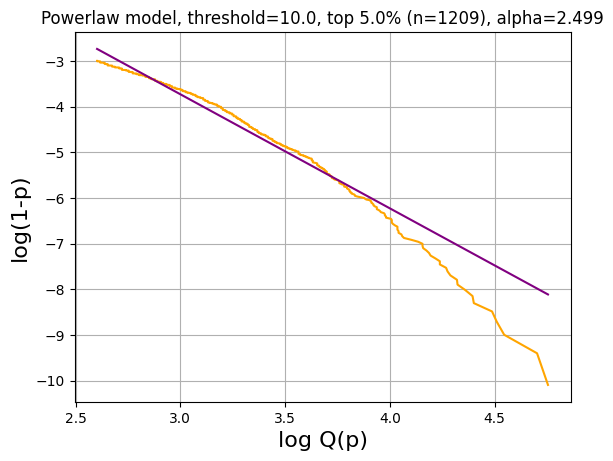

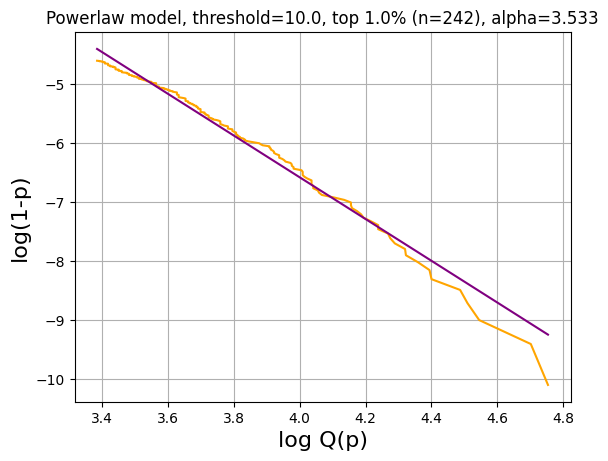

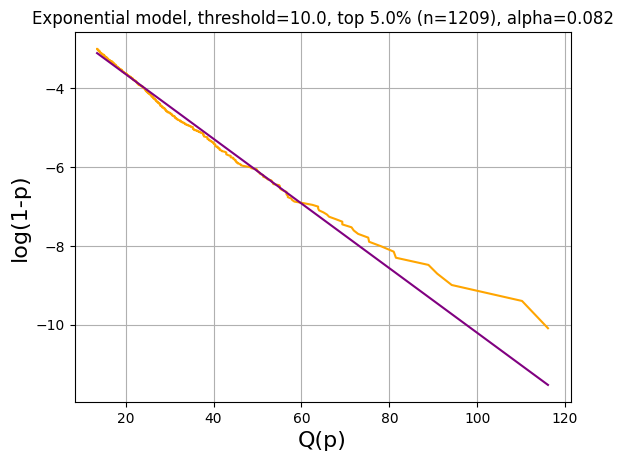

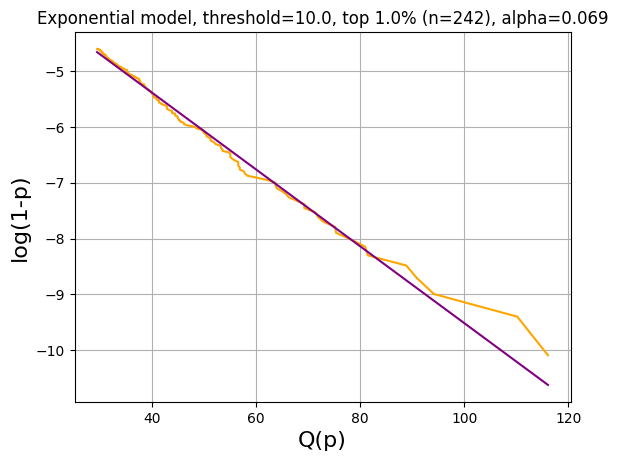

In [47]:
for family in ["powerlaw", "exponential"]:
    for p0 in [0.05, 0.01]:
        plt.subplot(2, 2, i)
        plot_tails(df["PRCP"], p0, thresh, family)
        plt.show()

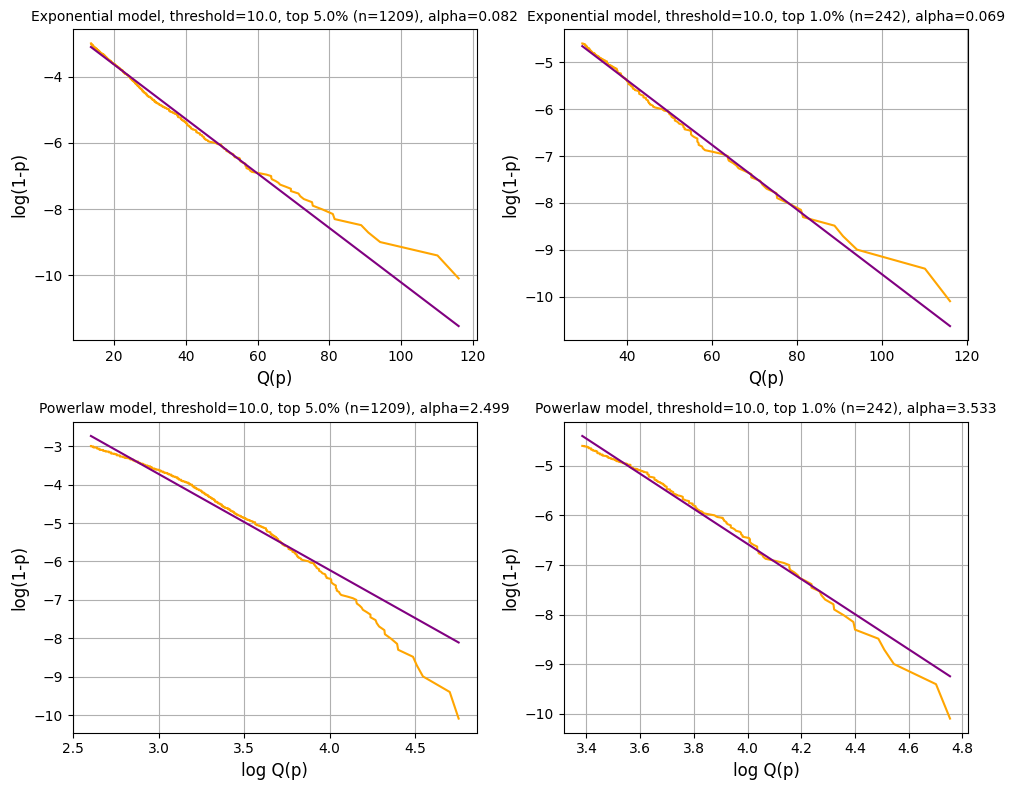

In [51]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

plot_tails(axs[0, 0], df["PRCP"], p0=0.05, thresh=10, family="exponential")
plot_tails(axs[0, 1], df["PRCP"], p0=0.01, thresh=10, family="exponential")
plot_tails(axs[1, 0], df["PRCP"], p0=0.05, thresh=10, family="powerlaw")
plot_tails(axs[1, 1], df["PRCP"], p0=0.01, thresh=10, family="powerlaw")

plt.tight_layout()
plt.savefig("tail_plot")

Below is a "Hill plot" suggesting that the tail index might be around 3.

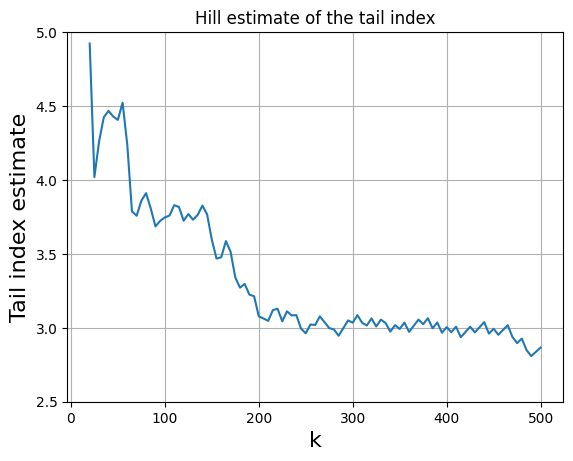

In [31]:
plot_hill(df["PRCP"])

Next we fit generalized extreme value distributions to the block (annual) maxima.  The m-returns based on the GEV model are printed and a qq-plot showing the goodness of fit of the GEV to the data is displayed.

   Years      Return
0     10   77.265260
1    100  128.083204
2    500  178.715938
3   1000  205.734056


/var/folders/1m/g_2xpnh912g613fymwqbt4gr0000gn/T/ipykernel_97826/1636911525.py:13: FutureWarning: The provided callable <function amax at 0x120a4e480> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  yrmx = dx.groupby("year")["PRCP"].agg(np.max)


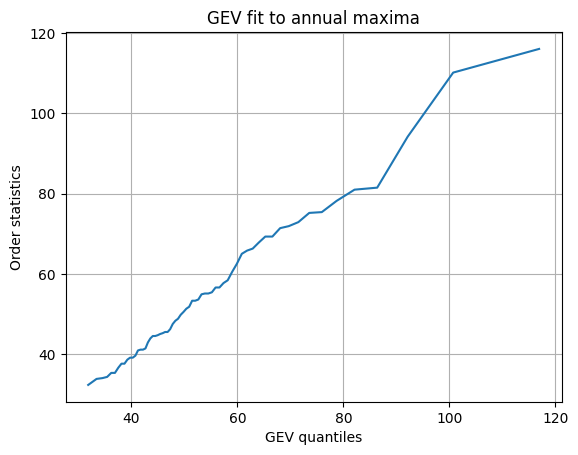

In [32]:
gev = block_max(df)

Below is the shape parameter of the best-fitting GEV to the block maxima.  Due to the parameterization of the GEV used by Scipy, the tail index is -1/shape.

In [33]:
gev.args

(-0.19008398255730877,)

In [34]:
-1/gev.args[0]

5.2608325359476735

Fit generalized Pareto models to the exceedances

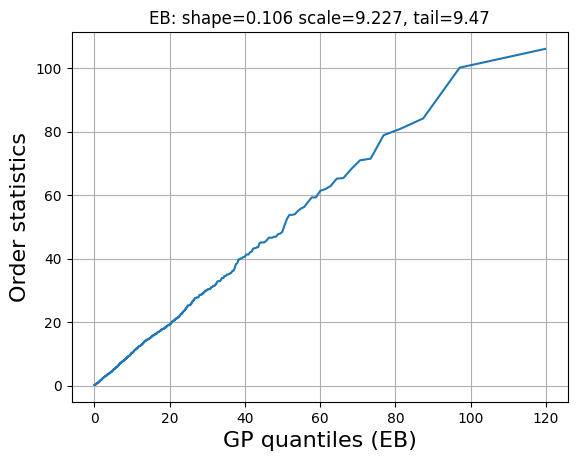

In [57]:
eb = eb_analysis(df["PRCP"], thresh)

Next we calculate m-observation returns based on an exponential and a generalized Pareto model fit to the 24 hour rainfall totals.

In [36]:
yr = np.r_[1, 10, 100, 500, 1000]
cfg = [("exponential", None), ("generalizedpareto", eb)]
for (f,g) in cfg:
    print("\nReturns based on %s:" % f)
    mr = mobs_return(df["PRCP"], 365 * yr, thresh, family=f, gp=g)
    rr = pd.DataFrame({"Years": yr, "MR": mr})
    print(rr)


Returns based on exponential:
Mean = 10.31
   Years          MR
0      1   43.884008
1     10   67.627417
2    100   91.370827
3    500  107.966758
4   1000  115.114237

Returns based on generalizedpareto:
Shape=0.11
Scale=9.23
   Years          MR
0      1   46.246545
1     10   80.276159
2    100  123.672811
3    500  160.918236
4   1000  179.014885


The cell below is a simple demonstration of how to use the gp_estimate function defined above.  Note that there are different parameterizations of the generalized Pareto distribution (this is true of many probability distributions).  Since we are using [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genpareto.html), here we use the parameterization adopted by scipy, which is also the parameterization shown on [wikipedia](https://en.wikipedia.org/wiki/Generalized_Pareto_distribution).  The shape parameter $\xi$ is the reciprocal of the tail index $\alpha$, i.e. $\alpha = 1/\xi$.

In [37]:
shape = 1/3.
scale = 1

# Generate data and obtain an estimated GPD using the empirical Bayes approach.
eb, z = check_gp_estimate(shape=shape, scale=scale, thresh=0)

# Check that the population and sample medians match (if they don't something is wrong)
print("Sample median =", np.median(z))
print("Population median =", scale*(2**shape - 1) / shape)

# The fitted GPD has this shape parameter
print("Fitted GPD shape parameter: ", eb.args)

# This is the estimated tail index
print("Estimated tail index: ", 1 / eb.args[0])
print("Population tail index: ", 1 / shape)

Sample median = 0.7767931226423662
Population median = 0.7797631496846196
Fitted GPD shape parameter:  (0.32461050043799516,)
Estimated tail index:  3.0806150714493383
Population tail index:  3.0
